# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import uniform, randint
import joblib
import matplotlib.pyplot as plt
import os
import warnings
import shap

warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [2]:
TRAIN_PATH = "./db/train_data.csv"
VAL_PATH   = "./db/val_data.csv"
TEST_PATH  = "./db/test_data.csv"
TARGET_COL = "label"
DROP_COLS  = ["patient_id", "date"]

# Datasets

In [3]:
train = pd.read_csv(TRAIN_PATH)
val   = pd.read_csv(VAL_PATH)
test  = pd.read_csv(TEST_PATH)

In [4]:
X_train = train.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in train.columns])
y_train = train[TARGET_COL].copy()
X_val   = val.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in val.columns])
y_val   = val[TARGET_COL].copy()
X_test  = test.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in test.columns])
y_test  = test[TARGET_COL].copy()

# Modelagem

In [5]:
def resample_train(X, y, target_ratio=1.0, random_state=42):
    target_ratio = 2
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name=TARGET_COL)

    pos_idx = y[y == 1].index.to_numpy()
    neg_idx = y[y == 0].index.to_numpy()

    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    if n_pos == 0 or n_neg == 0:
        return X.reset_index(drop=True), y.reset_index(drop=True)

    n_neg_target = int(n_pos * float(target_ratio))

    rng = np.random.RandomState(random_state)


    neg_keep = rng.choice(neg_idx, size=n_neg_target, replace=False)


    extra_needed = n_neg_target - n_pos
    pos_extra = rng.choice(pos_idx, size=extra_needed, replace=True)
    pos_keep = np.concatenate([pos_idx, pos_extra])

#     pos_keep = pos_idx

    keep_idx = np.concatenate([neg_keep, pos_keep])
    rng.shuffle(keep_idx)

    X_res = X.loc[keep_idx].reset_index(drop=True)
    y_res = y.loc[keep_idx].reset_index(drop=True)

    return X_res, y_res

def evaluate(model, X, y, set_name="set"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    cm = confusion_matrix(y, y_pred)

    print(f"\n---------------------------------- Avaliação no {set_name} ---------------------------------\n")
    print("Accuracy:", acc)
    print("\nClassification report:\n", report)
    print("Confusion matrix:\n", cm)

    unique_classes = np.unique(y)
    if len(unique_classes) == 2 and y_proba is not None:
        auc = roc_auc_score(y, y_proba)
        print("\nROC AUC:", auc)
        fpr, tpr, thr = roc_curve(y, y_proba)
        plt.figure(figsize=(12, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve - {set_name}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return {"accuracy": acc, "report_str": report, "confusion_matrix": cm}

In [6]:
# Pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=True, random_state=RANDOM_STATE, class_weight="balanced"))
])

In [7]:
# Definição de espaço de buscam do Random Search
param_distributions = {
    "svc__C": uniform(loc=0.01, scale=100),
    "svc__gamma": uniform(loc=1e-6, scale=1),
    "svc__kernel": ["rbf", "poly", "sigmoid"],
    "svc__degree": randint(2, 6),
    "svc__coef0": uniform(loc=0, scale=1)
}

In [8]:
cv = TimeSeriesSplit(n_splits=5)
n_iter = 10
X_train_fit = X_train
y_train_fit = y_train

In [9]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring="accuracy",
    cv=cv,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)

# Fit com Dados Reais

In [10]:
random_search.fit(X_train_fit, y_train_fit)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a2fe44a4740>,
                                        'svc__coef0': <...nfrastructure.rv_continuous_frozen object at 0x7a2fe542d0d0>,
                                        'svc__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a2fe44a4c20>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a2fe44a4a40>,
                                        'svc__kernel': ['rbf', 'poly',
                                                        'sigmoid']},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [11]:
best_model = random_search.best_estimator_

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score CV (scoring chosen):", random_search.best_score_)

Melhores parâmetros encontrados:
{'svc__C': np.float64(78.52759613930137), 'svc__coef0': np.float64(0.19967378215835974), 'svc__degree': 4, 'svc__gamma': np.float64(0.9832318858067882), 'svc__kernel': 'rbf'}

Melhor score CV (scoring chosen): 0.9179640718562874


# Avaliação com Dados Reais


---------------------------------- Avaliação no validation ---------------------------------

Accuracy: 0.9404761904761905

Classification report:
               precision    recall  f1-score   support

           0     0.9405    1.0000    0.9693       316
           1     0.0000    0.0000    0.0000        20

    accuracy                         0.9405       336
   macro avg     0.4702    0.5000    0.4847       336
weighted avg     0.8845    0.9405    0.9116       336

Confusion matrix:
 [[316   0]
 [ 20   0]]

ROC AUC: 0.610996835443038


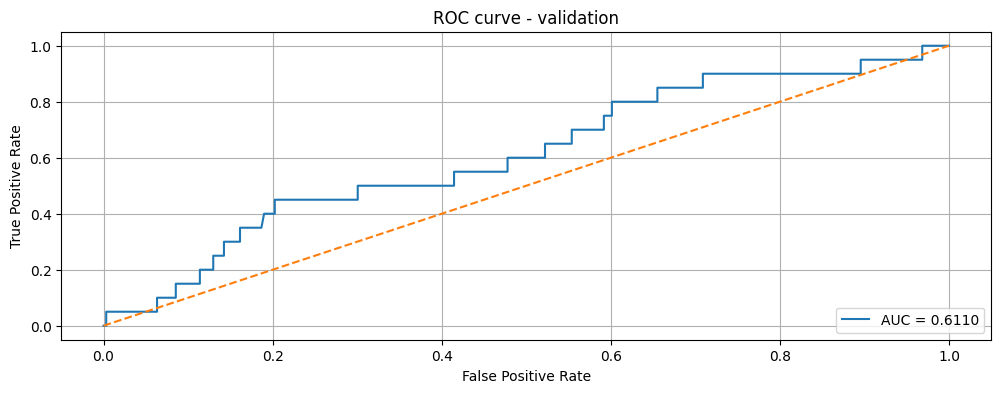


---------------------------------- Avaliação no test ---------------------------------

Accuracy: 0.8461538461538461

Classification report:
               precision    recall  f1-score   support

           0     0.8462    1.0000    0.9167       385
           1     0.0000    0.0000    0.0000        70

    accuracy                         0.8462       455
   macro avg     0.4231    0.5000    0.4583       455
weighted avg     0.7160    0.8462    0.7756       455

Confusion matrix:
 [[385   0]
 [ 70   0]]

ROC AUC: 0.5088497217068646


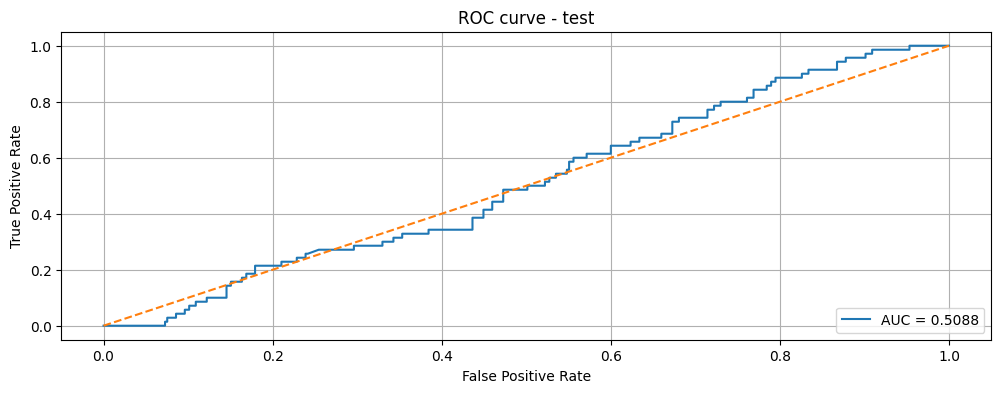

In [12]:
res_val = evaluate(best_model, X_val, y_val, set_name="validation")
res_test = evaluate(best_model, X_test, y_test, set_name="test")

# Fit com Resample

In [13]:
X_train_res, y_train_res = resample_train(X_train, y_train, target_ratio=1.0, random_state=RANDOM_STATE)

random_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a2fe44a4740>,
                                        'svc__coef0': <...nfrastructure.rv_continuous_frozen object at 0x7a2fe542d0d0>,
                                        'svc__degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a2fe44a4c20>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a2fe44a4a40>,
                                        'svc__kernel': ['rbf', 'poly',
                                                        'sigmoid']},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [14]:
best_model_res = random_search.best_estimator_

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score CV (scoring chosen):", random_search.best_score_)

Melhores parâmetros encontrados:
{'svc__C': np.float64(60.121501174320876), 'svc__coef0': np.float64(0.7080725777960455), 'svc__degree': 3, 'svc__gamma': np.float64(0.05641257902710026), 'svc__kernel': 'poly'}

Melhor score CV (scoring chosen): 0.7682242990654206


# Avaliação com Resample


---------------------------------- Avaliação no validation ---------------------------------

Accuracy: 0.8452380952380952

Classification report:
               precision    recall  f1-score   support

           0     0.9583    0.8734    0.9139       316
           1     0.1667    0.4000    0.2353        20

    accuracy                         0.8452       336
   macro avg     0.5625    0.6367    0.5746       336
weighted avg     0.9112    0.8452    0.8735       336

Confusion matrix:
 [[276  40]
 [ 12   8]]

ROC AUC: 0.7289556962025316


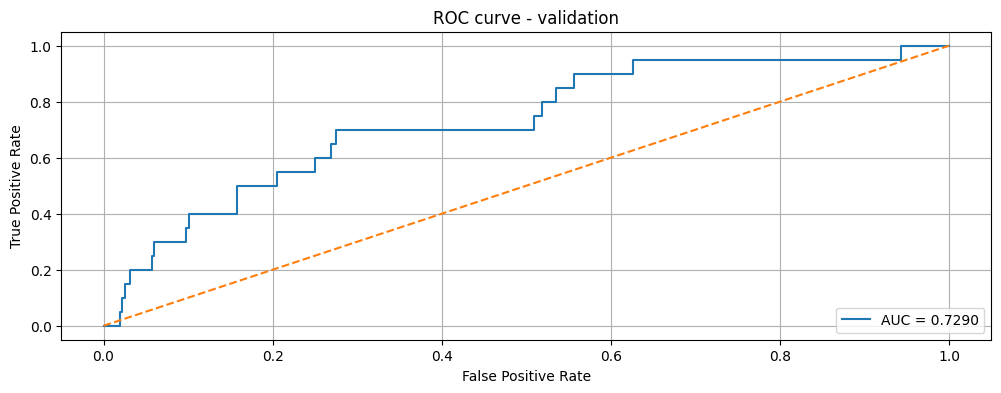


---------------------------------- Avaliação no test ---------------------------------

Accuracy: 0.7296703296703296

Classification report:
               precision    recall  f1-score   support

           0     0.8680    0.8026    0.8340       385
           1     0.2323    0.3286    0.2722        70

    accuracy                         0.7297       455
   macro avg     0.5502    0.5656    0.5531       455
weighted avg     0.7702    0.7297    0.7476       455

Confusion matrix:
 [[309  76]
 [ 47  23]]

ROC AUC: 0.6135250463821892


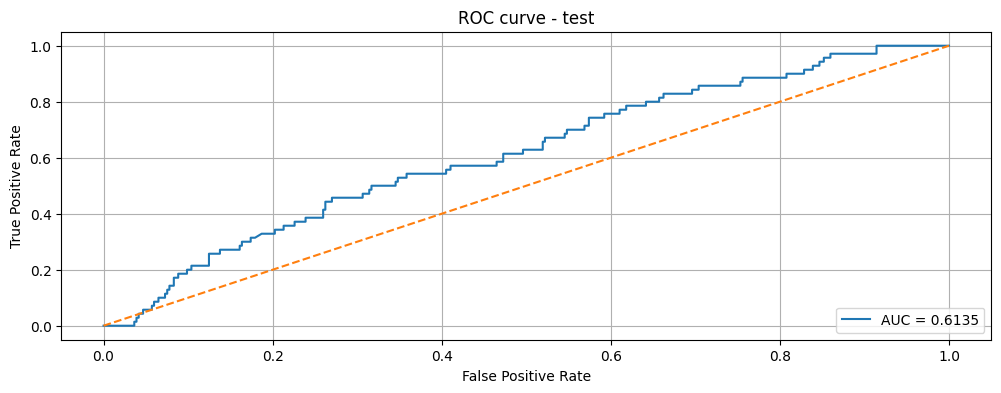

In [15]:
res_val = evaluate(best_model_res, X_val, y_val, set_name="validation")
res_test = evaluate(best_model_res, X_test, y_test, set_name="test")